In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("src")

In [3]:
%matplotlib inline

from abc                  import abstractmethod
from numpy                import inf
from plotting             import plot_overlapping
from torch                import Tensor
from torch.nn             import Parameter
from torch.nn.functional  import softmax, sigmoid
from torch_geometric.nn   import GCN
from torch_geometric.data import Data
from typing               import Dict, List, Tuple

import networkx as nx
import torch

In [4]:
# create smart teleportation flow matrix and flow distribution as described
#  - https://arxiv.org/abs/2311.04036
#  - https://www.nature.com/articles/ncomms5630
def mkSmartTeleportationFlow(A, alpha = 0.15, iter = 1000, device : str = "cpu"):
    # build the transition matrix
    T = torch.nan_to_num(A.T * (torch.sum(A, 1)**(-1.0)).to_dense(), nan = 0.0).T.to(device = device)

    # distribution according to nodes' in-degrees
    e_v = (torch.sum(A, dim = 0) / torch.sum(A)).to_dense().to(device = device)

    # calculate the flow distribution with a power iteration
    p = e_v
    for _ in range(iter):
        p = alpha * e_v + (1-alpha) * p @ T
    
    # make the flow matrix for minimising the map equation
    F = alpha * A / torch.sum(A) + (1-alpha) * (p * T.T).T
    
    return F, p

In [5]:
# We encode the map equation loss in a pooling operator, but are actually
# only interested in the codelength for now
class MapEquationPooling(torch.nn.Module):
    def __init__(self, adj: Tensor, device : str = "cpu", *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.adj       = adj
        self.F, self.p = mkSmartTeleportationFlow(self.adj, device = device)

        # this term is constant, so only calculate it once
        self.p_log_p = torch.sum(self.p * torch.nan_to_num(torch.log2(self.p), nan = 0.0))

    def forward(self, x, s):
        C      = s.T @ self.F @ s
        diag_C = torch.diag(C)

        q   = 1.0 - torch.trace(C)
        q_m = torch.sum(C, dim = 1) - diag_C
        m_exit = torch.sum(C, dim = 0) - diag_C
        p_m = q_m + torch.sum(C, dim = 0)

        codelength = torch.sum(q      * torch.nan_to_num(torch.log2(q),      nan = 0.0)) \
                   - torch.sum(q_m    * torch.nan_to_num(torch.log2(q_m),    nan = 0.0)) \
                   - torch.sum(m_exit * torch.nan_to_num(torch.log2(m_exit), nan = 0.0)) \
                   - self.p_log_p \
                   + torch.sum(p_m    * torch.nan_to_num(torch.log2(p_m),    nan = 0.0))

        x_pooled   = torch.matmul(s.T, x)
        adj_pooled = s.T @ self.adj @ s

        return x_pooled, adj_pooled, codelength

In [6]:
def sparse_from_networkx(G : nx.Graph) -> Tuple[torch.Tensor, Dict[int, int]]:
    """
    Converts a networkx graph to a sparse tensor.

    Parameters
    ----------
    G : nx.Graph
        The networkx graph, which can be weighted and/or directed.

    Returns
    ------
    Tuple[torch.Tensor, Dict[int, int]]
        A tuple containing the sparse tensor representation of the input graph
        and a dictionary from zero-based IDs to the original node names.
    """

    # always make sure to sort the nodes so they're in the expected order
    the_nodes  = list(sorted(G.nodes))
    node_to_ID = { node:ID for (ID,node) in enumerate(the_nodes) }
    ID_to_node = { ID:node for (ID,node) in enumerate(the_nodes) }

    indices = [[],[]]
    values  = []
    for u in the_nodes:
        for v in sorted(G.neighbors(u)): # again, always sorting...
            weight = 1.0
            data   = G.get_edge_data(u, v)
            if "weight" in data:
                weight = data["weight"]
            indices[0].append(node_to_ID[u])
            indices[1].append(node_to_ID[v])
            values.append(float(weight))
    
    return ( torch.sparse_coo_tensor( indices = indices
                                    , values  = values
                                    , size    = (len(the_nodes), len(the_nodes))
                                    )
           , ID_to_node
           )

In [7]:
def to_dataset(G: nx.Graph, y_true: List[int]) -> Data:
    """
    Takes a networkx graph and a list of community labels for the nodes and
    returns them as a pyg Data representation.

    Parameters
    ----------
    G : nx.Graph
        The networkx graph.

    y_true : List[int]
        List of the nodes' community labels.

    Returns
    -------
    Data
        A Data object where the edge index and node features X are a sparse
        tensor representation of the graph's adjacency matrix and the node
        labels a the nodes' true communities.
    """
    data = Data()
    data.edge_index = sparse_from_networkx(G)[0].coalesce()
    data.x          = sparse_from_networkx(G)[0].coalesce()
    data.y          = torch.Tensor(y_true).long()

    return data

In [8]:
# A clusterer that runs the optimisation.
# The missing ingredient: a specific forward method (next cell).
class Clusterer(torch.nn.Module):
    def __init__(self, model, device: str = "cpu") -> None:
        super().__init__()

        self.model  = model
        self.device = device

    @abstractmethod
    def forward(self, x):
        raise NotImplementedError(f"forward not implemented on {self._get_name()}")

    def fit(self, data: Data, epochs: int, patience: int, lr: float):
        self.data = data.to(self.device)
        x = self.data.x.to_dense()

        l_best : float  = inf  # best loss
        s_best : Tensor = None # best cluster

        optimizer = torch.optim.Adam(self.parameters(), lr = lr)

        epoch          = 0
        no_improvement = 0

        while epoch < epochs and no_improvement < patience:
            self.train()
            optimizer.zero_grad()

            loss, s = self.forward(x = x)
            print(f"[Epoch {epoch:4}] L = {loss:.8f} bits")
            loss.backward()
            optimizer.step()

            self.eval()
            with torch.no_grad():
                loss, s = self.forward(x = x)

                if loss < l_best:
                    l_best         = float(loss)
                    no_improvement = 0
                    s_best         = s
                else:
                    no_improvement += 1

                epoch += 1


        return l_best, s_best

In [9]:
# Neuromap inherits from Clusterer and defines the specific forward method.
class Neuromap(Clusterer):
    def __init__(self, model, device: str = "cpu") -> None:
        super().__init__(model = model, device = device)

        # softmax temperature
        self.t = Parameter(torch.zeros(1)).to(device = self.device)


    def forward(self, x):
        s = softmax(self.model(x, self.data.edge_index) / sigmoid(self.t), dim = 1)

        if self.training:
            s = s + 1e-8

        _, _, loss = self.pool(x = x, s = s)

        return loss, s


    def fit(self, data: Data, epochs: int, patience: int, lr: float):
        self.data = data.to(device = self.device)
        self.pool = MapEquationPooling(adj = data.edge_index, device = self.device)
        
        return super().fit(data = data, epochs = epochs, patience = patience, lr = lr)

In [10]:
# define an example network
G = nx.Graph()
G.add_edges_from([(1,2), (1,3), (1,4), (2,3), (2,4), (3,4), (3,5), (4,5), (5,6), (5,7), (6,7), (6,8), (6,9), (7,8), (7,9), (8,9)])

n = G.number_of_nodes()

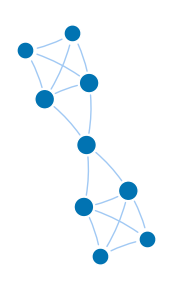

In [11]:
plot_overlapping(G, S = torch.tensor([[1,1,1,1,1,1,1,1,1]]).T, figsize = (3,3))

In [12]:
data = to_dataset(G = G, y_true = [])

In [13]:
model = GCN( in_channels     = n
           , hidden_channels = n
           , num_layers      = 2
           , out_channels    = 3
           , act             = "selu"
           , norm            = "batch"
           , dropout         = 0.5
           )

neuromap = Neuromap(model = model, device = "cpu")

In [14]:
# setting a high learning rate for this example
# sometimes, the GNN takes a "wrong turn", so in general, it's a good idea to run several trials
L, S = neuromap.fit(data, epochs = 1000, patience = 100, lr = 1e-1)

[Epoch    0] L = 3.55721450 bits
[Epoch    1] L = 3.14398789 bits
[Epoch    2] L = 3.11850834 bits
[Epoch    3] L = 2.93518734 bits
[Epoch    4] L = 2.86772156 bits
[Epoch    5] L = 2.84825015 bits
[Epoch    6] L = 2.89344883 bits
[Epoch    7] L = 2.84984827 bits
[Epoch    8] L = 2.85653186 bits
[Epoch    9] L = 2.85684347 bits
[Epoch   10] L = 2.85494399 bits
[Epoch   11] L = 2.85684061 bits
[Epoch   12] L = 2.85684252 bits
[Epoch   13] L = 2.85684443 bits
[Epoch   14] L = 2.85684419 bits
[Epoch   15] L = 2.85684657 bits
[Epoch   16] L = 2.84807682 bits
[Epoch   17] L = 2.85677433 bits
[Epoch   18] L = 2.85684466 bits
[Epoch   19] L = 2.85493898 bits
[Epoch   20] L = 2.84714842 bits
[Epoch   21] L = 2.84923744 bits
[Epoch   22] L = 2.85106015 bits
[Epoch   23] L = 2.85684299 bits
[Epoch   24] L = 2.85683870 bits
[Epoch   25] L = 2.85684443 bits
[Epoch   26] L = 2.85683942 bits
[Epoch   27] L = 2.85684490 bits
[Epoch   28] L = 2.85595536 bits
[Epoch   29] L = 2.84691072 bits
[Epoch   3

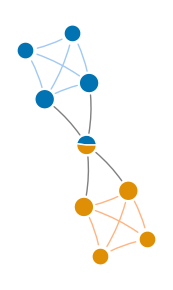

In [15]:
plot_overlapping(G = G, S = S, figsize = (3,3))